In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# Set directory as default system path
import sys
sys.path.append('/content/drive/MyDrive/smart-pixels')

Mounted at /content/drive


In [26]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from custom_callbacks import CustomCallback
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Flatten, Dropout, LeakyReLU
from keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt

Num GPUs Available:  1


In [27]:
data = pd.read_csv(sys.path[-1] + "/data/resampled200K.csv")

In [28]:
X, local_y, pT = data[data.columns[:273]].values.reshape(data.shape[0],13,21,1), data["local_y"].values, data["pT"].values
print(X.shape, local_y.shape, pT.shape)

(200000, 13, 21, 1) (200000,) (200000,)


In [5]:
X_train, X_test, Y_loc_train, Y_loc_test, pT_train, pT_test = train_test_split(
    X,
    local_y,
    pT,
    test_size = 0.15,
    random_state = 0,
    shuffle = True
)

scaler1 = StandardScaler()
X_train = scaler1.fit_transform(X_train.reshape(-1, X_train.shape[0])).reshape(X_train.shape[0],13,21,1)
X_test = scaler1.fit_transform(X_test.reshape(-1, X_test.shape[0])).reshape(X_test.shape[0],13,21,1)

scaler2 = StandardScaler()
Y_loc_train = scaler2.fit_transform(Y_loc_train.reshape(Y_loc_train.shape[0],1)).ravel()
Y_loc_test = scaler2.fit_transform(Y_loc_test.reshape(Y_loc_test.shape[0],1)).ravel()

In [33]:
from keras.layers import concatenate
from keras.regularizers import L2
class ClassificationModel:

    def build_image_branch(self,inputA):
      regularizer = L2(l2 = 0.0005)
      x = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer= 'he_normal',
                 kernel_regularizer = regularizer, activation = 'relu')(inputA)
      x = BatchNormalization()(x)
      x = Conv2D(16, (3, 3), strides=(1, 1), kernel_initializer= 'he_normal', 
                  kernel_regularizer = regularizer, activation = 'relu')(x)
      x = BatchNormalization()(x)
      outputA = Flatten()(x)
      return outputA
    
    def build_image_with_y_loc_branch(self,outputA, inputB):
        merged_x = concatenate([outputA, inputB])
        regularizer = L2(l2 = 0.0005)
        x = Dense(16, kernel_initializer= 'he_normal', 
                  kernel_regularizer = regularizer, activation = 'relu')(merged_x)
        x = BatchNormalization()(x)
        x = Dense(8 , kernel_initializer= 'he_normal', 
                  kernel_regularizer = regularizer, activation = 'relu')(x)
        x = BatchNormalization()(x)
        x = Dense(1, activation= "relu", name = "final_output")(x)

        return x
 
    def assemble_model(self):
        inputA, inputB = Input ( shape = (13,21,1) ), Input ( shape = (1,) )
        outputA = self.build_image_branch(inputA)
        final_output = self.build_image_with_y_loc_branch(outputA, inputB)
        model = Model(inputs =[inputA, inputB], outputs=final_output, name = "pT_model")
        print( model.summary() )
        return model

In [ ]:
model = ClassificationModel().assemble_model()

checkpoint_path = "./models/pT_class_output_model_cp.ckpt"

# Create a callback that saves the model's weights 
# currently, model weights are saved for each training
# to do - update for early stopping
# cp_callback = ModelCheckpoint(filepath=checkpoint_path,
#                               save_weights_only=True,
#                               verbose=1,
#                               save_best_only = True)

es = EarlyStopping(monitor = "val_loss", patience = 10, mode = "max")
csv_logger = CSVLogger('log.csv', append=True, separator=';')
batch_size = 64
epochs = 200

optim= tf.keras.optimizers.Adam(lr = 0.01, decay = 1-5)

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = optim,
              metrics = ["accuracy"])
history = model.fit(
          x = (X_train, Y_loc_train),
          y = pT_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True,
          validation_data = [(X_test, Y_loc_test), pT_test],
          callbacks=[csv_logger],
          )

Model: "pT_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 13, 21, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 11, 19, 32)   320         ['input_17[0][0]']               
                                                                                                  
 batch_normalization_32 (BatchN  (None, 11, 19, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_17 (Conv2D)             (None, 9, 17, 16)    4624        ['batch_normalization_32[0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
2657/2657 [==============================] - 14s 5ms/step - loss: 3.9253 - accuracy: 0.5006 - val_loss: 2.8915 - val_accuracy: 0.5057
Epoch 2/200
2657/2657 [==============================] - 12s 5ms/step - loss: 2.6113 - accuracy: 0.4990 - val_loss: 2.1618 - val_accuracy: 0.5004
Epoch 3/200
2657/2657 [==============================] - 12s 5ms/step - loss: 2.0608 - accuracy: 0.4992 - val_loss: 1.6580 - val_accuracy: 0.4960
Epoch 4/200
2657/2657 [==============================] - 12s 5ms/step - loss: 1.6976 - accuracy: 0.4983 - val_loss: 1.4115 - val_accuracy: 0.4951
Epoch 5/200
2657/2657 [==============================] - 12s 5ms/step - loss: 1.4495 - accuracy: 0.4979 - val_loss: 1.3163 - val_accuracy: 0.4976
Epoch 6/200
2657/2657 [==============================] - 12s 5ms/step - loss: 1.3323 - accuracy: 0.5010 - val_loss: 1.1621 - val_accuracy: 0.4981
Epoch 7/200
2657/2657 [==============================] - 12s 5ms/step - loss: 1.2849 - accuracy: 0.4997 - val_loss: 1.1260 -

In [ ]:
plt.figure(figsize = (5,4), dpi = 80)
plt.plot(history.history["loss"], color = "red")
plt.plot(history.history["val_loss"], color = "black")
plt.legend(["training", "validation"])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.25', alpha=0.5,color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.25', alpha=0.5,color='black')
plt.show()

In [ ]:
import sklearn
predictions = model.predict([X_test,Y_loc_test], batch_size=batch_size, callbacks=[CustomCallback()])
y_preds = predictions.argmax(axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(pT_test,y_preds))

Start predicting; got log keys: []
Stop predicting; got log keys: []


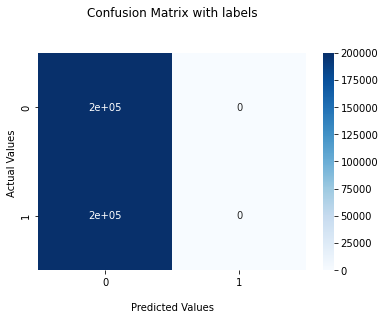

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict([X_test,Y_loc_test], batch_size=batch_size, callbacks=[CustomCallback()])
y_preds = predictions.argmax(axis=1)
cf_matrix = confusion_matrix(pT_test, y_preds)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# def saving_model(model,
#                  filepath:str ='',
#                  model_filename:str ='model'):
#     """
#     Helper function to save the trained pruned models in the following format:
#         Config -> JSON file format
#         Weights -> H5PY file format
#     :param model: Keras Model object
#     :param filepath: path to store the file in the directory
#     :param model_filename: name for the model
#     :return: None
#     """ 
#     # serialize model to JSON
#     model_json = model.to_json()
#     with open(filepath + "/" + model_filename + ".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights(filepath + "/" + model_filename + "_weights.h5")
#     print("Saved model to disk")

In [ ]:
# saving_model(model, filepath = sys.path[-1] + "/" + "models", model_filename = "reg_model_pT")